### Analysis of Yelp data result

In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
%matplotlib inline

In [2]:
!ls -alt *.pkl

-rw-r--r-- 1 root root  3439414 Mar  3 01:53 MNARxMARyelp_log35_13.pkl
-rw-r--r-- 1 root root  3580726 Mar  2 23:40 MNARxMARyelp_log35_23.pkl
-rw-r--r-- 1 root root  3727342 Mar  2 18:55 MNARxMARyelp_log35_33.pkl
-rw-r--r-- 1 root root    60214 Feb 29 07:14 MNARyelp_log35.pkl
-rw-r--r-- 1 root root    60214 Feb 19 15:30 MNARyelp_log35_Cb30.pkl
-rw-r--r-- 1 1004 1004    60214 Feb 16 16:50 MNARyelp_log35_largeCb.pkl
-rw-r--r-- 1 1004 1004    53960 Feb 14 16:52 MNARyelp_linear.pkl
-rw-r--r-- 1 1004 1004    53960 Feb 12 12:47 MARyelp_linear.pkl
-rw-rw-r-- 1 1004 1004    80160 Feb 11 09:27 Ymat.pkl
-rw-rw-r-- 1 1004 1004 41600163 Feb 11 09:27 Xsps.pkl
-rw-rw-r-- 1 1004 1004  2080162 Feb 11 09:27 Xmat.pkl
-rw-rw-r-- 1 1004 1004    60214 Feb 11 09:27 MARyelp_log35.pkl


In [3]:
MARress = []
MNARress = []

In [4]:
#with open("./MARyelp_linear.pkl", "rb") as f:
with open("./MARyelp_log35.pkl", "rb") as f:
    MARres = pickle.load(f)
    
#with open("./MNARyelp_linear.pkl", "rb") as f:
with open("./MNARyelp_log35.pkl", "rb") as f:
    MNARres = pickle.load(f)

MARress.append(MARres)
MNARress.append(MNARres)

In [5]:
with open("./MNARxMARyelp_log35_13.pkl", "rb") as f:
    MNARxMAR13 = pickle.load(f)
MARress.append(MNARxMAR13["MARres"])
MNARress.append(MNARxMAR13["MNARres"])

In [6]:
with open("./MNARxMARyelp_log35_23.pkl", "rb") as f:
    MNARxMAR23 = pickle.load(f)
MARress.append(MNARxMAR23["MARres"])
MNARress.append(MNARxMAR23["MNARres"])

In [7]:
with open("./MNARxMARyelp_log35_33.pkl", "rb") as f:
    MNARxMAR33 = pickle.load(f)
MARress.append(MNARxMAR33["MARres"])
MNARress.append(MNARxMAR33["MNARres"])

In [8]:
def AUCplot(MARres, MNARres, i, is_plot=False):
    marres,  mnarres = MARres[i], MNARres[i]
    marprobs, margts = marres[0].cpu().numpy(), marres[1].cpu().numpy()
    mnarprobs, mnargts = mnarres[0].cpu().numpy(), mnarres[1].cpu().numpy()
    marfpr, martpr, marthre = metrics.roc_curve(margts, marprobs)
    mnarfpr, mnartpr, mnarthre = metrics.roc_curve(mnargts, mnarprobs)
    marauc = metrics.roc_auc_score(margts, marprobs)
    mnarauc = metrics.roc_auc_score(mnargts, mnarprobs)
    if is_plot:
        plt.title("ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.plot(marfpr, martpr, "--r", label="MAR")
        plt.plot(mnarfpr, mnartpr, label="MNAR")
        plt.legend()
    return marauc, mnarauc
    

In [9]:
allaucdfs = []

In [10]:
for MARres, MNARres in zip(MARress, MNARress):
    allaucs = [AUCplot(MARres, MNARres, i)  for i in range(1, 21)] 
    allaucs = np.array(allaucs)
    allaucdf = pd.DataFrame(allaucs)
    allaucdf.columns = ["MAR", "MNAR"]
    allaucdfs.append(allaucdf)

In [8]:
MARprobs = []
MARgt = []
MNARprobs = []
MNARgt = []
for i in range(1, len(MNARres)+1):
    mnarres = MNARres[i]
    MNARprobs.append(mnarres[0].cpu().numpy())
    MNARgt.append(mnarres[1].cpu().numpy())
for i in range(1, len(MARres)+1):
    marres = MARres[i]
    MARprobs.append(marres[0].cpu().numpy())
    MARgt.append(marres[1].cpu().numpy())

In [9]:
MARgt = np.concatenate(MARgt)
MNARgt = np.concatenate(MNARgt)
MARprobs = np.concatenate(MARprobs)
MNARprobs = np.concatenate(MNARprobs)

In [10]:
Data = {
    "Probs": np.concatenate([MNARprobs, MARprobs]),
    "Method": ["MNAR"] * len(MNARprobs) + ["MAR"] * len(MARprobs),
    "GT": np.concatenate([MNARgt, MARgt])
}
dfdata = pd.DataFrame(Data)

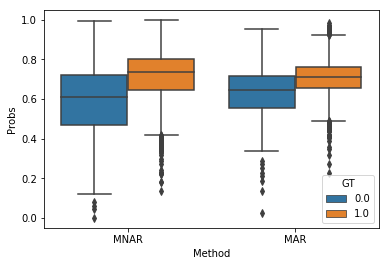

In [11]:
sns.boxplot(data=dfdata, x="Method", y="Probs", hue="GT")

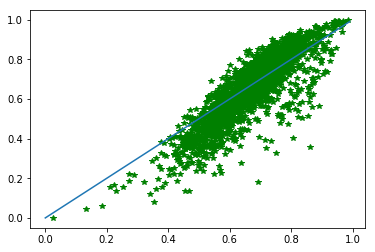

In [12]:
#plt.plot(MARgt[:200], "bo")
#plt.plot(MARgt[:200], MARprobs[:200], "rh")
#plt.plot(MARgt[:200], MNARprobs[:200], "g*")
plt.plot(MARprobs[:], MNARprobs[:], "g*")
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))

In [13]:
dfdatagrp = dfdata.groupby(["Method", "GT"])

In [14]:
dfdatagrp.describe()

Probs                                                    \
             count      mean       std       min       25%       50%   
Method GT                                                              
MAR    0.0   956.0  0.632270  0.111974  0.025569  0.555941  0.646408   
       1.0  2031.0  0.704438  0.095415  0.229004  0.653056  0.711972   
MNAR   0.0   956.0  0.588905  0.166331  0.000592  0.466515  0.610935   
       1.0  2031.0  0.714819  0.129726  0.135830  0.647006  0.735316   

                                
                 75%       max  
Method GT                       
MAR    0.0  0.716344  0.953771  
       1.0  0.761537  0.984909  
MNAR   0.0  0.719866  0.990624  
       1.0  0.800841  0.996755

In [15]:
from sklearn import metrics

In [16]:
metrics.roc_auc_score(MARgt, MARprobs)

0.6862089495662421

In [17]:
metrics.roc_auc_score(MNARgt, MNARprobs)

0.7235109979419418

In [18]:
marfpr, martpr, marthre = metrics.roc_curve(MARgt, MARprobs)
mnarfpr, mnartpr, mnarthre = metrics.roc_curve(MNARgt, MNARprobs)

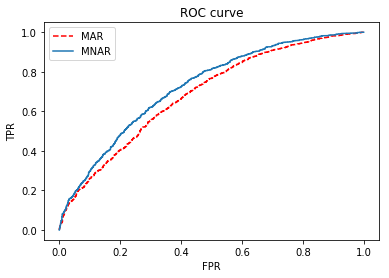

In [19]:
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(marfpr, martpr, "--r", label="MAR")
plt.plot(mnarfpr, mnartpr, label="MNAR")
plt.legend()

In [11]:
diffs = []
CIs = []
mdiffs = []
for allaucdf in allaucdfs:
    marres = np.array(allaucdf["MAR"])
    mnarres = np.array(allaucdf["MNAR"])
    diff = mnarres - marres
    mdiffs.append(np.mean(diff))
    diffs.append(diff)
    CIs.append([np.mean(diff) - 1.96* np.std(diff)/np.sqrt(len(diff)), np.mean(diff) + 1.96* np.std(diff)/np.sqrt(len(diff))])

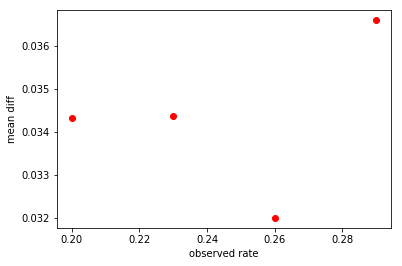

In [16]:
plt.xlabel("observed rate")
plt.ylabel("mean diff")
plt.plot([0.29, 0.26, 0.23, 0.20], mdiffs, "ro")

In [19]:
diffs

[array([ 0.08286252,  0.0624    ,  0.00265636,  0.05231931,  0.08668076,
         0.03973064,  0.06217693, -0.01758893,  0.0080289 ,  0.00212766,
        -0.0036846 ,  0.09497301,  0.01219793,  0.03715729,  0.07252488,
         0.02533744,  0.02656503,  0.04754902, -0.00162338,  0.03967697]),
 array([0.03313466, 0.02161463, 0.03935595, 0.03129512, 0.02194144,
        0.02677931, 0.0237545 , 0.05368991, 0.03655174, 0.02313193,
        0.04689901, 0.04166667, 0.03401961, 0.05807812, 0.01993518,
        0.02337213, 0.0399785 , 0.03371028, 0.04714416, 0.03130995]),
 array([0.02640384, 0.03443738, 0.03108717, 0.03586404, 0.04006107,
        0.02162665, 0.02675107, 0.04598703, 0.03708107, 0.03606198,
        0.04261869, 0.04169006, 0.04597087, 0.03609692, 0.02873211,
        0.02683096, 0.02684889, 0.01550388, 0.05225011, 0.03471207])]

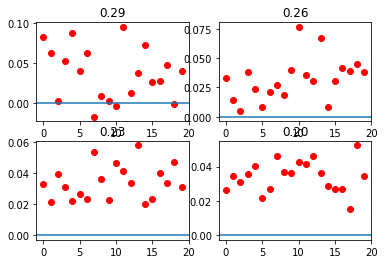

In [21]:
plt.subplot(221)
plt.title("0.29")
plt.plot(diffs[0], "or")
plt.axhline(0)
plt.subplot(222)
plt.title("0.26")
plt.plot(diffs[1], "or")
plt.axhline(0)
plt.subplot(223)
plt.title("0.23")
plt.plot(diffs[2], "or")
plt.axhline(0)
plt.subplot(224)
plt.title("0.20")
plt.plot(diffs[3], "or")
plt.axhline(0)

In [ ]:
plt.boxplot(diffs)